In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/LabProject')

In [3]:
using_colab = 1
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-ebhgiaag
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-ebhgiaag
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.8 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp311-cp

In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [6]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 16.7 MB/s eta 0:00:00


In [7]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from utils.general import check_device
import torch
from torchmetrics import JaccardIndex
from PIL import Image
import numpy as np
import pandas as pd
from functions.creating_list import get_base_filename, load_boxes, load_points, load_three_points, exctract_paths
import pickle
import matplotlib
import matplotlib.pyplot as plt
import cv2
from functions.mask import extract_true_mask_json
from functions.sam2_functions import show_mask, show_points, show_box, show_masks

In [8]:
# Load predictor
sam2_checkpoint = 'checkpoints/sam2.1_hiera_large.pt'
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

In [9]:
color_map = {1: [0,0,255],
             2: [255,255,255], # nero perchè tanto non c'è nel test set lul
             3: [255,0,0],
             4: [0,255,255],
             5: [255,255,0],
             6: [255,0,255],
             7: [0,255,0]}

color_map = {k: np.array(color_map[k])/255 for k in color_map}
color_map

{1: array([0., 0., 1.]),
 2: array([1., 1., 1.]),
 3: array([1., 0., 0.]),
 4: array([0., 1., 1.]),
 5: array([1., 1., 0.]),
 6: array([1., 0., 1.]),
 7: array([0., 1., 0.])}

In [15]:
# seg8k_video12_015810, t50_VID10_000660, t50_VID74_001380

# seg8k_video12_019580, t50_VID49_001290, t50_VID49_001500, t50_VID78_000517

from matplotlib.patches import Rectangle
image_path = 'image/Cholect_dataset/images/test/t50_VID74_001380.png'
box_path = 'image/cholect_annotation/bbox/test/t50_VID74_001380.txt'
label_path = 'image/cholect_annotation/classes/test/t50_VID74_001380.txt'
points_path = 'image/cholect_annotation/points/test/t50_VID74_001380.txt'
three_pts_path = 'image/cholect_annotation/three_points/test/t50_VID74_001380.txt'

image = Image.open(image_path)
image_width, image_height = image.size
image = np.array(image.convert("RGB"))
predictor.set_image(image)

bbox = load_boxes(box_path, image_width, image_height, 0)
pts = load_points(points_path, image_width, image_height, 0)
three_pts = load_three_points(three_pts_path, image_width, image_height, 0)

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=bbox[None, :],
    multimask_output=False,
)
masks = np.squeeze(masks)

combined_mask = np.max(masks, axis=0)

# Load the points (coordinates)
# input_point = np.array(pts)

# combined_mask = []
# # Iterate over each point (create one-hot label for each point)
# for idx in range(len(input_point)):
#     # Create a one-hot encoded label where only the current point has "1"
#     input_label = np.zeros(len(input_point))
#     input_label[idx] = 1


#     # Make the prediction for the current label configuration
#     masks, scores, logits = predictor.predict(
#         point_coords=input_point,
#         point_labels=input_label,
#         multimask_output=True
#     )

#     sorted_ind = np.argsort(scores)[::-1]
#     masks = masks[sorted_ind]
#     scores = scores[sorted_ind]
#     logits = logits[sorted_ind]
#     best_mask = masks[0]

#     combined_mask.append(best_mask)

# combined_mask = np.max(combined_mask, axis=0)

# input_point = np.array(three_pts)

# pred_masks = []
# input_labels = []
# # Iterate over the points in steps of 3
# for idx in range(0, len(input_point), 3):
#     # Create a label array with zeros
#     input_label = np.zeros(len(input_point))
#     # Set the 3 consecutive points to 1 (idx, idx+1, idx+2)
#     input_label[idx:idx+3] = 1
#     # Append the label array to the list of labels
#     input_labels.append(input_label)

# # Convert the list of labels into a numpy array after the loop
# input_labels = np.array(input_labels)

# # Iterate over the input_labels for prediction
# pred_masks = []
# for input_label in input_labels:
#     # Make the prediction for the current label configuration
#     masks, scores, logits = predictor.predict(
#         point_coords=input_point,
#         point_labels=input_label,
#         multimask_output=True
#     )

#     sorted_ind = np.argsort(scores)[::-1]
#     masks = masks[sorted_ind]
#     scores = scores[sorted_ind]
#     logits = logits[sorted_ind]
#     best_mask = masks[0]

#     pred_masks.append(best_mask)

# combined_mask = np.max(pred_masks, axis=0)

In [18]:
# Crea un'immagine RGB con la stessa forma della maschera, ma con 3 canali (RGB)
overlay_image = np.zeros((combined_mask.shape[0], combined_mask.shape[1], 3), dtype=np.float32)

overlay_image[combined_mask == 1] = [1, 0, 0]  # Rosso

In [12]:
# Mappa delle parole ai numeri
map_dict = {
    'grasper': 1,
    'snare': 2,
    'irrigator': 3,
    'clipper': 4,
    'scissors': 5,
    'bipolar': 6,
    'hook': 7
}

# Lista per memorizzare i risultati convertiti
converted_lines = []

# Leggi il file e sostituisci le parole con i numeri
with open(label_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        label_word = line.strip()  # Rimuovi eventuali spazi e nuove righe
        # Se la parola è nel dizionario, la sostituiamo con il numero
        if label_word in map_dict:
            converted_lines.append(str(map_dict[label_word]))  # Aggiungi il numero
        else:
            converted_lines.append(label_word)  # Se non trovata, mantieni la parola

# Mostra i risultati convertiti
for converted_line in converted_lines:
    print(converted_line)

type(converted_lines)

1
6


list

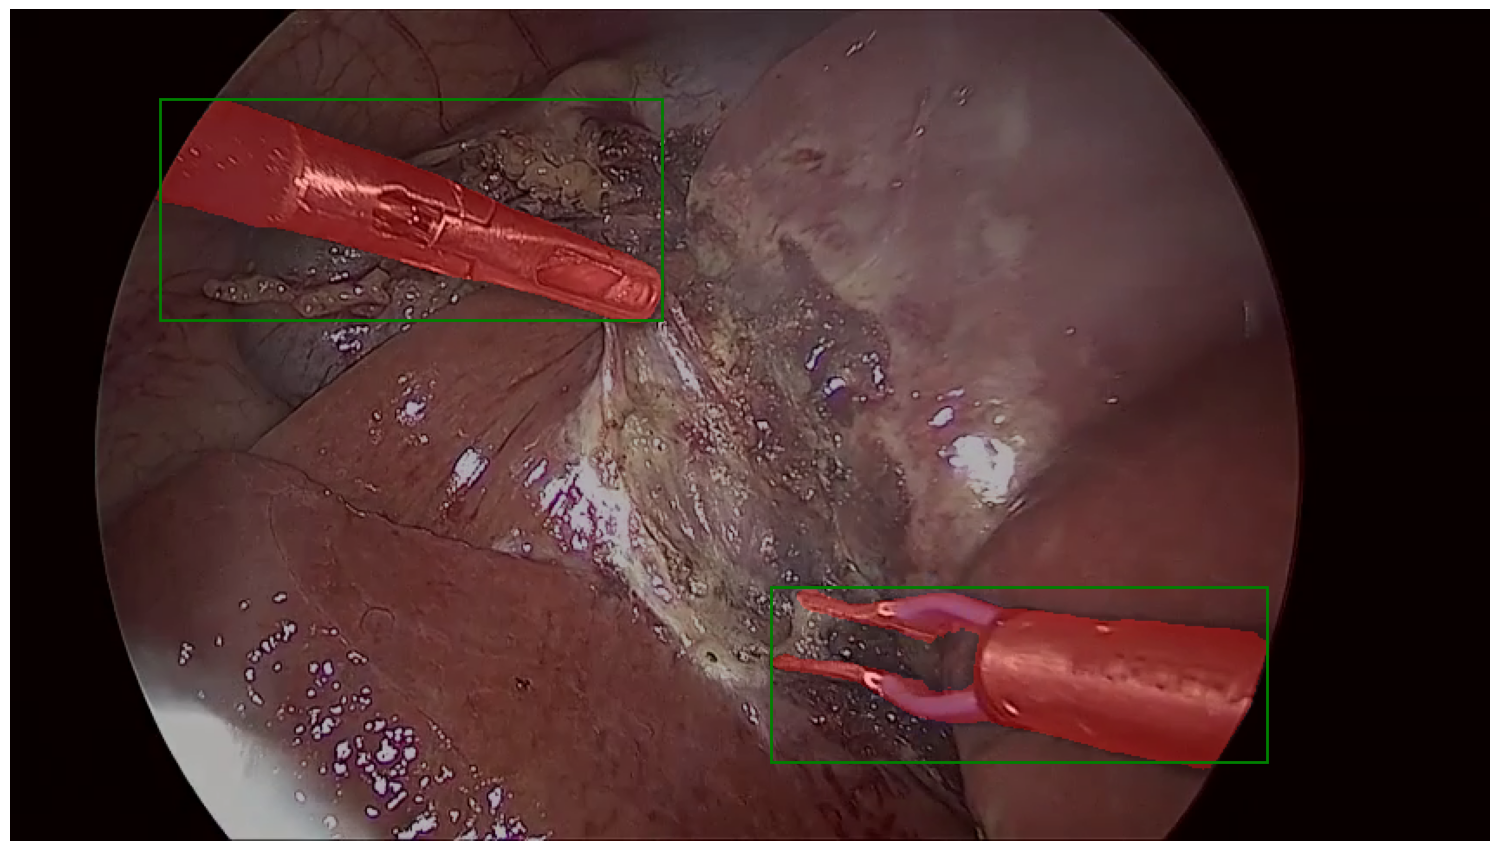

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Creazione della figura e dell'asse per il grafico
fig, ax = plt.subplots(1, 1, figsize=(19.2, 10.8), dpi=100)

# Mostra l'immagine
ax.imshow(image)

# Disegna le caselle di delimitazione (bounding boxes)
for bbox_item in bbox:
    x_min, y_min, x_max, y_max = bbox_item
    width = x_max - x_min
    height = y_max - y_min
    rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)

# Disegna i punti `pts`
#ax.scatter(pts[:, 0], pts[:, 1], color='green', s=100, label="Punti (pts)")

# Disegna i punti `three_pts`
#ax.scatter(three_pts[:, 0], three_pts[:, 1], color='green', s=100, label="Punti (three_pts)")

ax.imshow(overlay_image, alpha=0.3)


# Rimuovi gli assi per un display più pulito
ax.axis('off')

# Mostra il risultato
plt.savefig("t50_VID74_001380_three_pts.png")
plt.show()

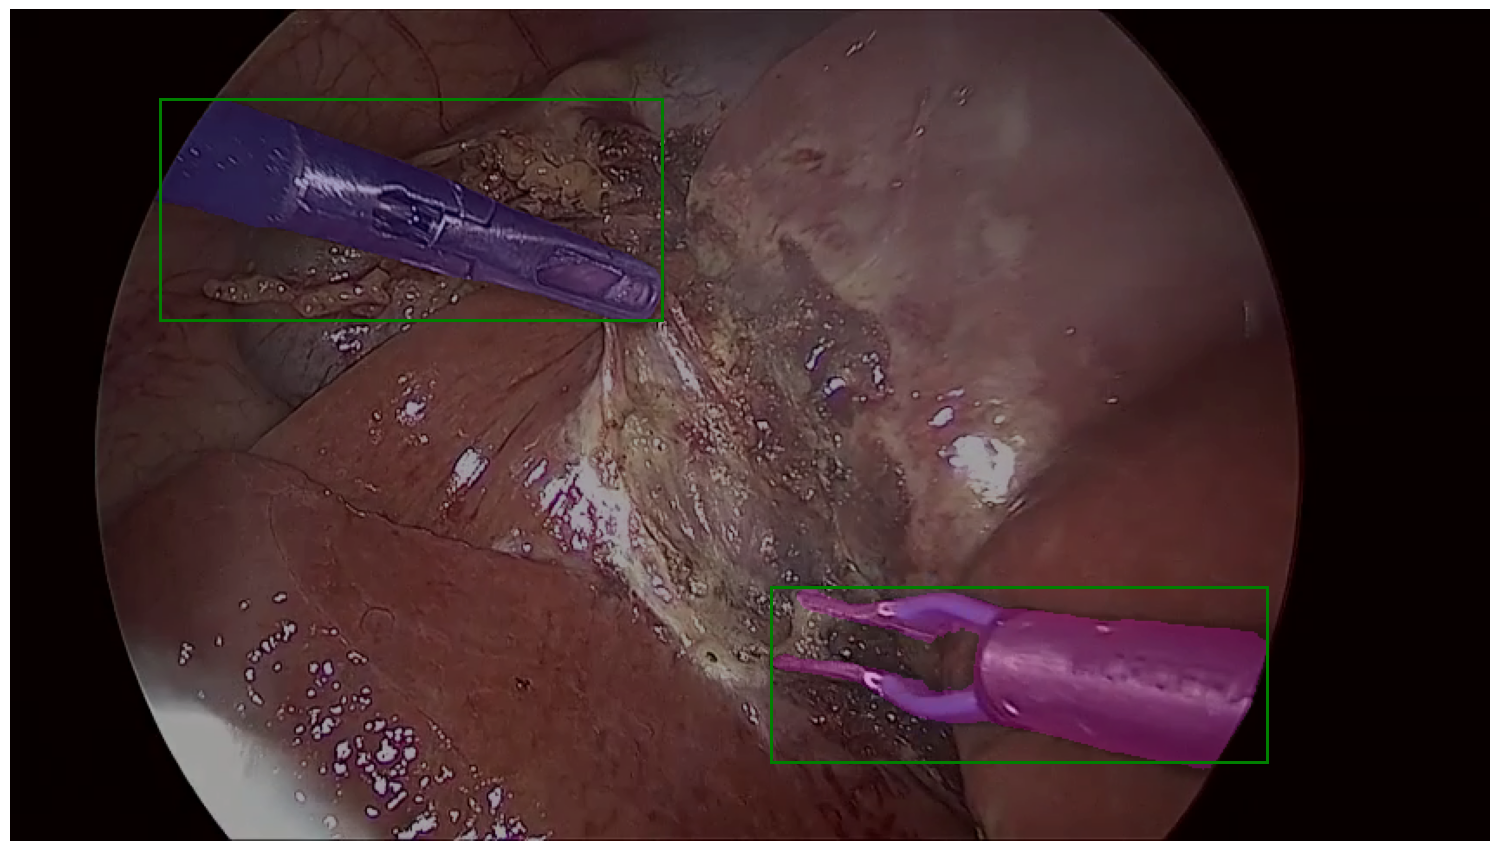

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(19.2, 10.8), dpi=100)
ax.imshow(image)
for i, l in enumerate(converted_lines):
    # Converti la stringa della classe in un numero intero
    class_id = int(l)  # Convertiamo la stringa in intero
    m = masks[i]  # Accedi alla maschera corrispondente
    m = m.squeeze()  # Assicurati che la maschera sia della forma (m, n)

    # Verifica che la classe esista nella mappa dei colori
    if class_id in color_map:
        # Crea l'immagine di sovrapposizione con il colore associato alla classe
        overlay_pred = np.zeros((*m.shape, 3))  # Un'immagine nera (0, 0, 0)
        overlay_pred[m == 1, :] = color_map[class_id]  # Imposta il colore della classe dove la maschera è 1

        # Sovrapponi l'immagine della maschera con alpha (trasparenza)
        ax.imshow(overlay_pred, alpha=0.2)
    else:
        print(f"Classe {class_id} non trovata nella mappa dei colori!")

    for bbox_item in bbox:
        x_min, y_min, x_max, y_max = bbox_item
        width = x_max - x_min
        height = y_max - y_min
        rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)

ax.axis('off')  # Remove axes
plt.savefig("t50_VID78_000517_SAM2.png")